In [1]:
import pandas as pd
import numpy as np
import pmdarima as pm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Load the dataset
data = pd.read_csv('gld_price_data.csv')
print(data.head())

       Date          SPX        GLD        USO     SLV   EUR/USD
0  1/2/2008  1447.160034  84.860001  78.470001  15.180  1.471692
1  1/3/2008  1447.160034  85.570000  78.370003  15.285  1.474491
2  1/4/2008  1411.630005  85.129997  77.309998  15.167  1.475492
3  1/7/2008  1416.180054  84.769997  75.500000  15.053  1.468299
4  1/8/2008  1390.189941  86.779999  76.059998  15.590  1.557099


In [3]:
df = data[['Date', 'GLD']].copy()
df['Date'] = pd.to_datetime(df['Date'])
print(df.head())

        Date        GLD
0 2008-01-02  84.860001
1 2008-01-03  85.570000
2 2008-01-04  85.129997
3 2008-01-07  84.769997
4 2008-01-08  86.779999


In [4]:
def fill_missing_values(df, column):
    # Lặp qua từng giá trị trong cột, tìm các giá trị thiếu (NaN)
    for idx in range(1, len(df) - 1):
        if pd.isna(df.loc[idx, column]):
            # Tìm giá trị trước đó không bị thiếu
            prev_idx = idx - 1
            while prev_idx >= 0 and pd.isna(df.loc[prev_idx, column]):
                prev_idx -= 1
            
            # Tìm giá trị sau đó không bị thiếu
            next_idx = idx + 1
            while next_idx < len(df) and pd.isna(df.loc[next_idx, column]):
                next_idx += 1

            # Nếu tìm được giá trị trước và sau, áp dụng công thức nội suy
            if prev_idx >= 0 and next_idx < len(df):
                a_value = df.loc[prev_idx, column]
                b_value = df.loc[next_idx, column]
                index_a = prev_idx
                index_b = next_idx
                index_x = idx

                # Công thức nội suy tuyến tính
                x_value = a_value + (index_x - index_a) / (index_b - index_a) * (b_value - a_value)
                
                # Điền giá trị đã tính vào vị trí thiếu
                df.loc[idx, column] = x_value

    return df
    
def fill_missing_values_date(df, date, column):
    # Tạo DataFrame với tất cả các ngày (bao gồm cả thứ 7, chủ nhật)
    all_days = pd.date_range(start=df[date].min(), end=df[date].max(), freq='D')
    df_all = pd.DataFrame({date: all_days})
    
    # Kết hợp dữ liệu gốc với DataFrame chứa tất cả các ngày
    df_merged = pd.merge(df_all, df, on=date, how='left')
    df_merged['index'] = range(1, len(df_merged) + 1)
    df_merged = fill_missing_values(df_merged, column)
    df_merged = df_merged.drop(columns=['index'])
    return df_merged

df = fill_missing_values_date(df, 'Date', 'GLD')
df.head(10)

,Date,GLD
0,2008-01-02,84.860001
1,2008-01-03,85.570000
2,2008-01-04,85.129997
3,2008-01-05,85.009997
4,2008-01-06,84.889997
5,2008-01-07,84.769997
6,2008-01-08,86.779999
7,2008-01-09,86.550003
8,2008-01-10,88.250000
9,2008-01-11,88.580002


In [5]:
df.set_index('Date', inplace=True)

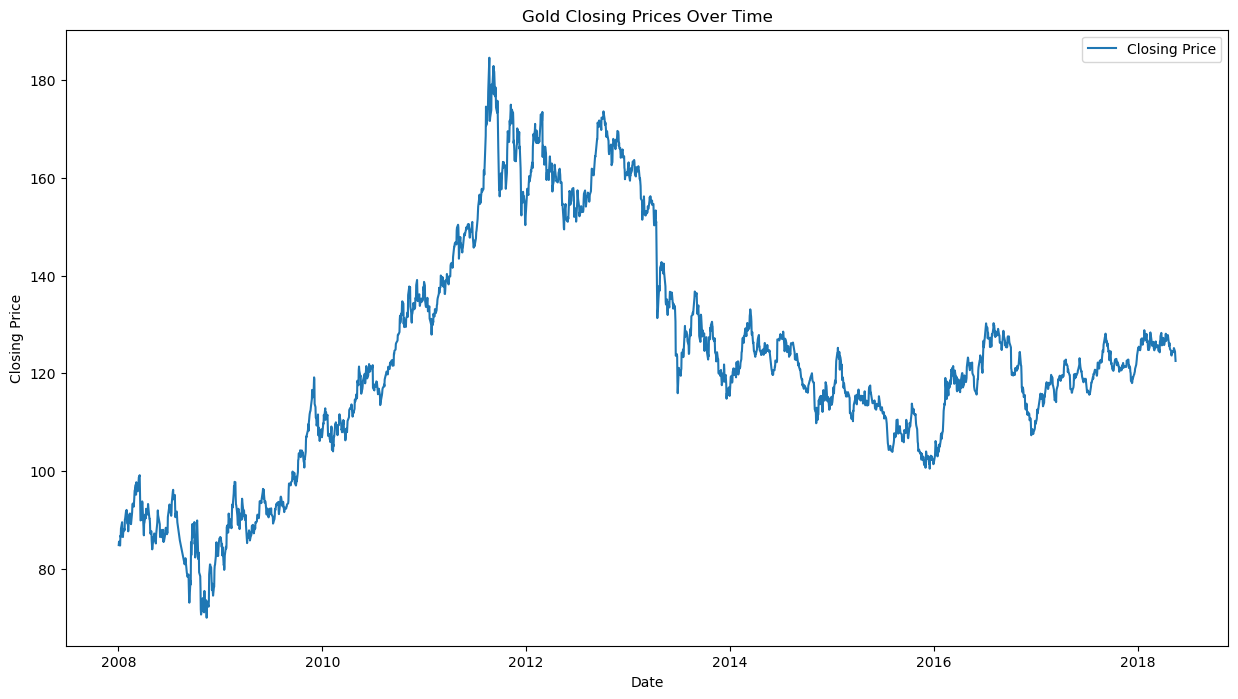

In [6]:
# Visualize the data
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['GLD'], label='Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Gold Closing Prices Over Time')
plt.legend()
plt.show()

In [7]:
# Create training and testing datasets
train_start_dt = '2008-01-01'
test_start_dt = '2017-01-01'
train = df.loc[train_start_dt:test_start_dt]
test = df.loc[test_start_dt:]
train.head()

,GLD
Date,
2008-01-02,84.860001
2008-01-03,85.570000
2008-01-04,85.129997
2008-01-05,85.009997
2008-01-06,84.889997


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 501 entries, 2017-01-01 to 2018-05-16
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GLD     501 non-null    float64
dtypes: float64(1)
memory usage: 7.8 KB


# Huan luyen model

In [9]:
# Sử dụng auto_arima để tìm tham số p, d, q tốt nhất
auto_arima_model = pm.auto_arima(train['GLD'], 
                                 start_p=1, start_q=1,  # Khởi đầu cho p và q
                                 max_p=5, max_q=5,  # Giới hạn tối đa của p và q
                                 start_d=0, max_d=5,  # Tìm d trong khoảng từ 0 đến 2 (hoặc hơn nếu cần)
                                 seasonal=False,  # Dữ liệu không có tính chu kỳ
                                 trace=True,  # Hiển thị kết quả của mỗi lần thử nghiệm
                                 stepwise=True)  # Sử dụng phương pháp tìm kiếm tối ưu


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9706.611, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9735.271, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9711.594, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9714.208, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9733.442, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9706.081, Time=0.71 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9704.100, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=9706.066, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=9707.568, Time=0.80 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=9702.230, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=9709.738, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=9704.195, Time=0.14 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=9704.211, Time=0.31 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=9704.740, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0]          

In [10]:
print(auto_arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3288
Model:               SARIMAX(2, 1, 0)   Log Likelihood               -4848.115
Date:                Sat, 19 Oct 2024   AIC                           9702.230
Time:                        00:20:28   BIC                           9720.523
Sample:                    01-02-2008   HQIC                          9708.779
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0835      0.010      8.103      0.000       0.063       0.104
ar.L2          0.0537      0.014      3.769      0.000       0.026       0.082
sigma2         1.1185      0.012     93.334      0.0

C:\Users\trumx\AppData\Local\Temp\ipykernel_22336\3194538051.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obs = test['GLD'][t]


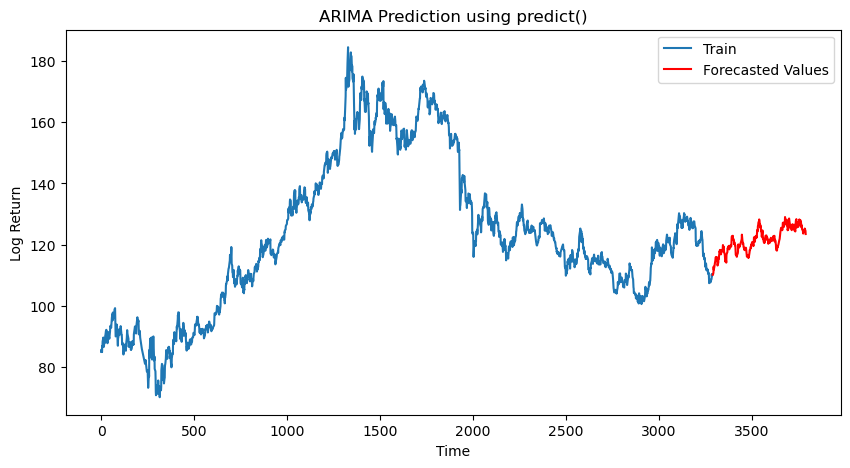

In [11]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

history = [x for x in train['GLD']]
predictions = list()

# walk-forward validation
for t in range(len(test['GLD'])):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test['GLD'][t]
    history.append(obs)

# Plot the original data and the forecast
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(train['GLD'])), train['GLD'], label="Train")
plt.plot(np.arange(len(train['GLD'])+1, len(train['GLD']) + len(test['GLD'])+1), predictions, label="Forecasted Values", color='red')
plt.title('ARIMA Prediction using predict()')
plt.xlabel('Time')
plt.ylabel('Log Return')
plt.legend()
plt.show()

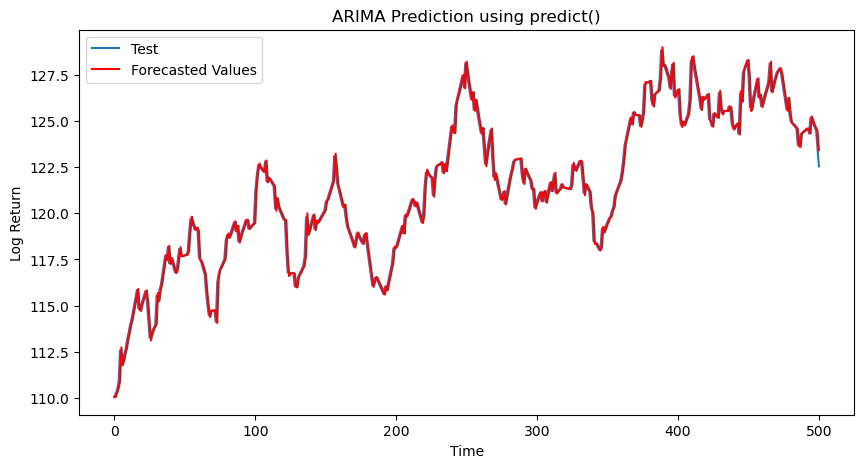

In [12]:
# Plot the original data and the forecast
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(test['GLD'])), test['GLD'], label="Test")
plt.plot(np.arange(len(test['GLD'])), predictions, label="Forecasted Values", color='red')
plt.title('ARIMA Prediction using predict()')
plt.xlabel('Time')
plt.ylabel('Log Return')
plt.legend()
plt.show()

In [13]:
# Tính toán các chỉ số đánh giá mô hình
mse = mean_squared_error(test['GLD'], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['GLD'], predictions)
mape = np.mean(np.abs((test['GLD'] - predictions) / test['GLD'])) * 100
r2 = r2_score(test['GLD'], predictions)

# In các chỉ số
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')
print(f'R²: {r2}')

MSE: 0.297848302042506
RMSE: 0.5457548002926828
MAE: 0.3884430057035625
MAPE: 0.3195327467670592%
R²: 0.9811114260956944


# có chuẩn hóa

In [14]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform it
train_scaled = train.copy()
train_scaled['GLD'] = scaler.fit_transform(train[['GLD']])

# Transform the test data using the same scaler
test_scaled = test.copy()
test_scaled['GLD'] = scaler.transform(test[['GLD']])

In [15]:
train_scaled

,GLD
Date,
2008-01-02,0.129680
2008-01-03,0.135876
2008-01-04,0.132036
2008-01-05,0.130989
2008-01-06,0.129942
...,...
2016-12-28,0.339122
2016-12-29,0.351601
2016-12-30,0.345667


In [16]:
# Find the best parameters using auto_arima on the scaled training data
auto_arima_model = pm.auto_arima(train_scaled['GLD'], 
                                 start_p=1, start_q=1,
                                 max_p=5, max_q=5,
                                 start_d=0, max_d=5,
                                 seasonal=False,
                                 trace=True,
                                 stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-21462.310, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-21434.433, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-21458.109, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-21455.434, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-21436.262, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-21463.609, Time=0.61 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-21465.604, Time=0.48 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-21463.638, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-21461.655, Time=0.72 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-21467.474, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-21459.966, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-21465.509, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-21465.480, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-21464.179, Time=0.07 sec
 ARIM

In [17]:
print(auto_arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3288
Model:               SARIMAX(2, 1, 0)   Log Likelihood               10736.737
Date:                Sat, 19 Oct 2024   AIC                         -21467.474
Time:                        00:21:14   BIC                         -21449.181
Sample:                    01-02-2008   HQIC                        -21460.925
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0836      0.010      8.113      0.000       0.063       0.104
ar.L2          0.0538      0.014      3.770      0.000       0.026       0.082
sigma2      8.518e-05   9.13e-07     93.340      0.0

In [18]:
# Walk-forward validation with the scaled data
history = [x for x in train_scaled['GLD']]
predictions = list()

for t in range(len(test_scaled['GLD'])):
    model = ARIMA(history, order=(2, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_scaled['GLD'][t]
    history.append(obs)

C:\Users\trumx\AppData\Local\Temp\ipykernel_22336\232680071.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obs = test_scaled['GLD'][t]


In [19]:
predictions_inverse = scaler.inverse_transform([predictions])[0]

In [20]:
# Tính toán các chỉ số đánh giá mô hình
mse = mean_squared_error(test['GLD'], predictions_inverse)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['GLD'], predictions_inverse)
mape = np.mean(np.abs((test['GLD'] - predictions_inverse) / test['GLD'])) * 100
r2 = r2_score(test['GLD'], predictions_inverse)

# In các chỉ số
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')
print(f'R²: {r2}')

MSE: 0.29784820894313396
RMSE: 0.5457547149985367
MAE: 0.3884403897219211
MAPE: 0.31953051478692734%
R²: 0.9811114319997548


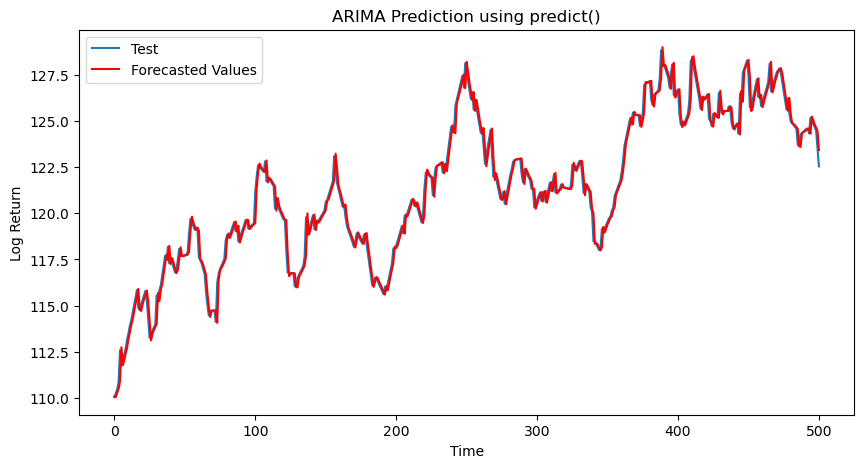

In [21]:
# Plot the original data and the forecast
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(test['GLD'])), test['GLD'], label="Test")
plt.plot(np.arange(len(test['GLD'])), predictions_inverse, label="Forecasted Values", color='red')
plt.title('ARIMA Prediction using predict()')
plt.xlabel('Time')
plt.ylabel('Log Return')
plt.legend()
plt.show()

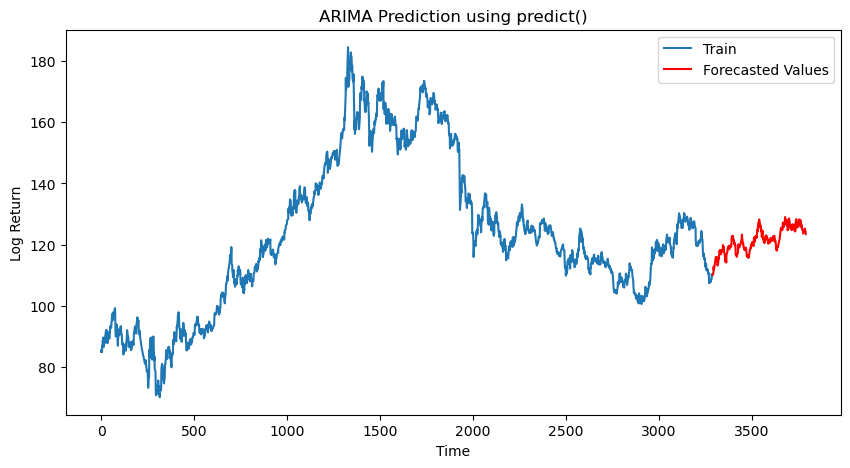

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(train['GLD'])), train['GLD'], label="Train")
plt.plot(np.arange(len(train['GLD'])+1, len(train['GLD']) + len(test['GLD'])+1), predictions_inverse, label="Forecasted Values", color='red')
plt.title('ARIMA Prediction using predict()')
plt.xlabel('Time')
plt.ylabel('Log Return')
plt.legend()
plt.show()